## 0. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv('C:\\Users\\Cliente\\Documents\\Git\\case\\docs\\parfum_sales.csv')

## 1. Ajustes

In [4]:
# analisando distribuicao de dados por dia

rows_per_day = df.groupby('day').size().reset_index(name='Row Count')
rows_per_day

,day,Row Count
0,1,14
1,2,12
2,3,4
3,4,5
4,5,16
5,6,16
6,7,8
7,8,51
8,9,19
9,10,16


In [5]:
# Normalização


# scaler = QuantileTransformer(output_distribution='normal')
# df['price_normalized'] = scaler.fit_transform(df[['price']])

# Inverse transform (correct way)
# df['price_original'] = scaler.inverse_transform(
#     df[['price_normalized']].rename(columns={'price_normalized': 'price'})
# )


# scaler = QuantileTransformer(output_distribution='normal')
# df['sold_normalized'] = scaler.fit_transform(df[['sold']])

# Inverse transform (correct way)
# df['sold_normalized'] = scaler.inverse_transform(
#     df[['sold_normalized']].rename(columns={'sold_normalized': 'sold'})
# )



####OBS: realizei a normalização, mas depois de modelar e fazer muuitos testes decidi não utiliza-la para manter uma melhor interpretação dos dados

<Axes: ylabel='sold'>

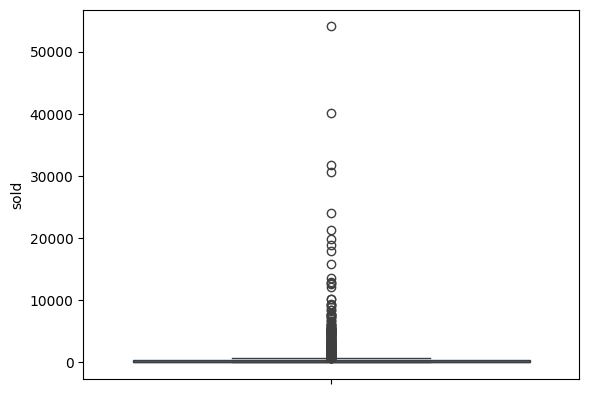

In [6]:
sns.boxplot(df['sold'])

com esse boxplot é possivel perceber o quanto de outliers existem, sendo assim fui fazendo testes até achar um valor que fizesse sentido ser considerado outlier e dividi a base em duas partes

In [7]:
# # removendo os outliers
# # mais de 200 produtos vendidos é um outlier assim como 0 produtos vendidos é irrelevante
df = df[df['sold'] != 0]
outlier_sales = df[df['sold'] >= 200]
comum_sales = df[df['sold'] < 100]


<Axes: ylabel='sold'>

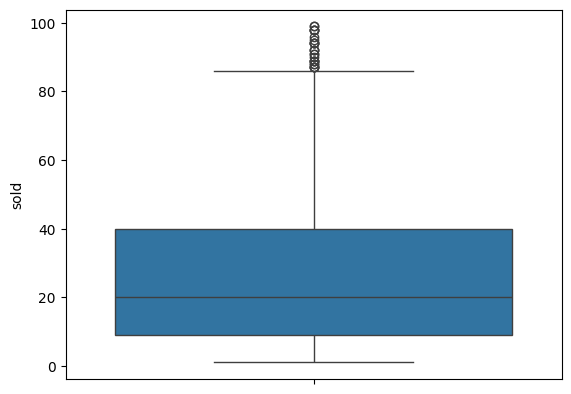

In [8]:
import seaborn as sns
sns.boxplot(comum_sales['sold'])

## 2. Treino e teste

In [9]:
def train_test_spli(db):
    train_size = int(len(db) * 0.7)
    train = db[:train_size]
    test = db[train_size:]
    return train, test

In [10]:
train_comum, test_comum = train_test_spli(comum_sales)

## 3. Modelos

In [11]:
def fit_arima_model(train_data, test, steps, order=(2, 1, 1)):
    arima_model = ARIMA(train_data['sold'], order=order)
    arima_fitted = arima_model.fit()
    arima_pred = arima_fitted.forecast(len(test))

    # prevendo os próximos dias
    arima_future_pred = arima_fitted.forecast(steps=steps)
    future_dates = pd.date_range(start=df['date'].max(), periods=11, freq='D')[1:]
    future_arima = pd.DataFrame({'date': future_dates, 'pred': arima_future_pred})
    return arima_pred, future_arima

arima_pred, future_arima = fit_arima_model(train_comum, test_comum, 10)

c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Cliente\App

In [ ]:
def fit_sarima_model(train_data, test, steps, order=(2, 1, 2), seasonal_order=(1, 1, 0, 7)):
    sarima_model = SARIMAX(train_data['sold'], order=order, seasonal_order=seasonal_order)
    sarima_fitted = sarima_model.fit()
    sarima_pred = sarima_fitted.forecast(steps=len(test))

    # prevendo os próximos dias
    sarima_future_pred = sarima_fitted.forecast(steps=steps)
    future_dates = pd.date_range(start=df['date'].max(), periods=11, freq='D')[1:]
    future_sarima = pd.DataFrame({'date': future_dates,  'pred': sarima_future_pred})
    return sarima_pred, future_sarima

sarima_pred, future_sarima = fit_sarima_model(train_comum, test_comum, 10)


c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an

,date,pred
0,2024-05-23,NaN
1,2024-05-23,NaN
2,2024-05-23,NaN
3,2024-05-23,NaN
4,2024-05-23,NaN
...,...,...
1064,NaN,35.431473
1065,NaN,-2.323998
1066,NaN,13.589308
1067,NaN,52.635887


## 4. Plotagem

C:\Users\Cliente\AppData\Local\Temp\ipykernel_6440\966214834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Cliente\AppData\Local\Temp\ipykernel_6440\966214834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date'])


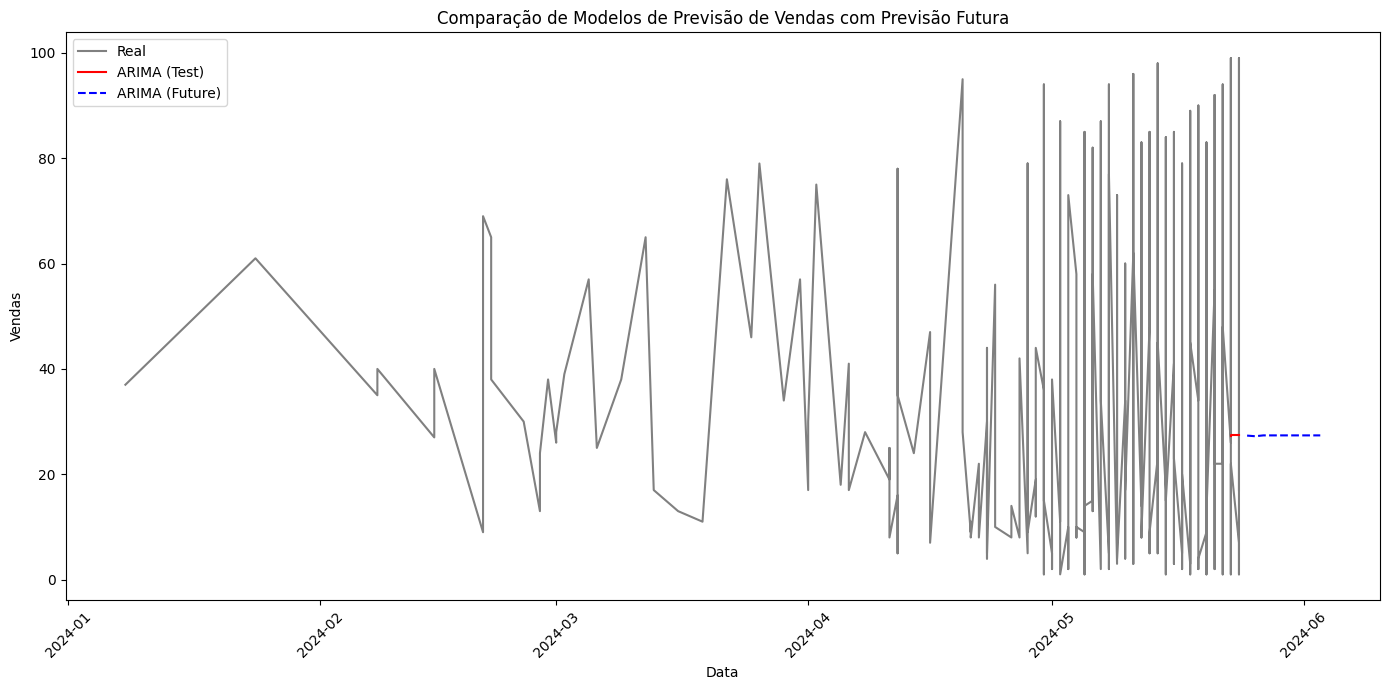

C:\Users\Cliente\AppData\Local\Temp\ipykernel_6440\966214834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\Cliente\AppData\Local\Temp\ipykernel_6440\966214834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date'])


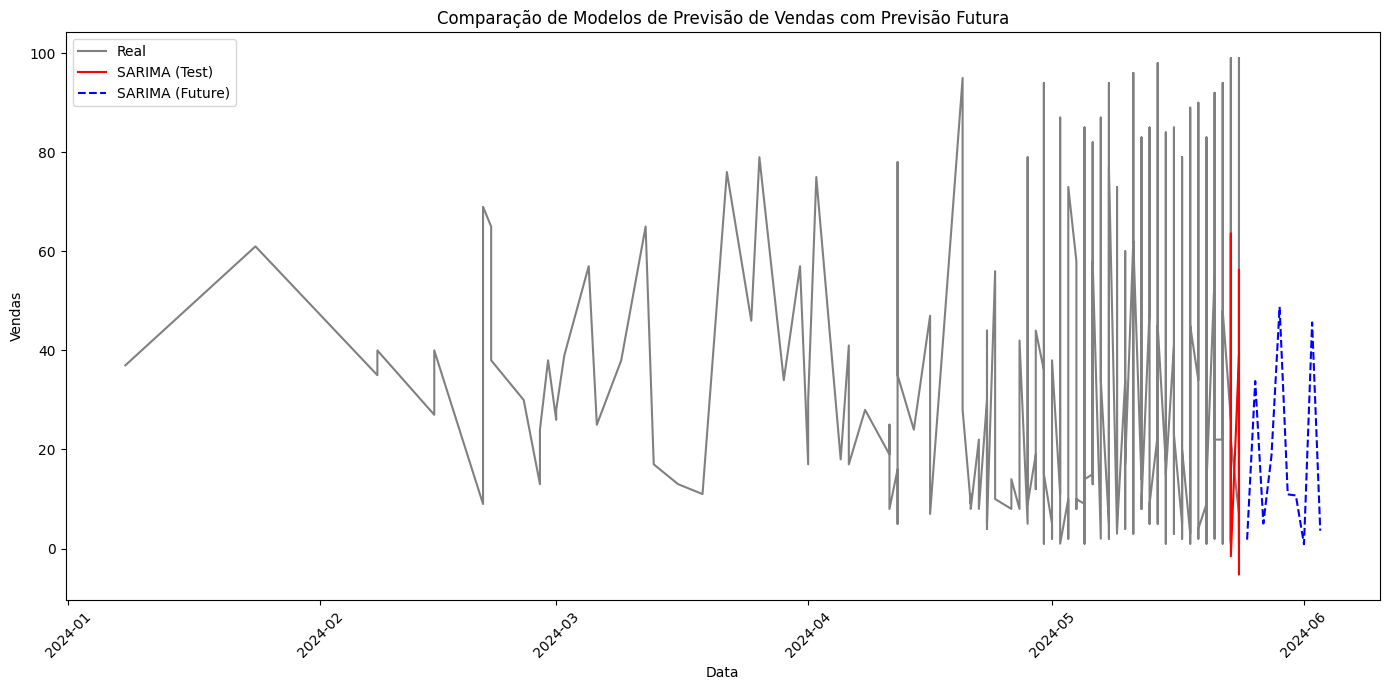

In [13]:
def plot_predictions_with_future(df, test, prediction, future, model_name):
    df['date'] = pd.to_datetime(df['date'])
    test['date'] = pd.to_datetime(test['date'])
    future['date'] = pd.to_datetime(future['date'])

    plt.figure(figsize=(14, 7))
    plt.plot(df['date'], df['sold'], color='grey', label='Real')
    plt.plot(test['date'], prediction, label=f'{model_name} (Test)', color='red')
    plt.plot(future['date'], future['pred'], label=f'{model_name} (Future)', color='blue', linestyle='--')
    plt.legend()
    plt.title('Comparação de Modelos de Previsão de Vendas com Previsão Futura')
    plt.xlabel('Data')
    plt.ylabel('Vendas')
    plt.xticks(rotation=45)  
    plt.tight_layout() 
    plt.show()

plot_predictions_with_future(comum_sales, test_comum, arima_pred, future_arima, 'ARIMA')
plot_predictions_with_future(comum_sales, test_comum, sarima_pred, future_sarima, 'SARIMA')


## 5. Avaliação

In [14]:
def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))

    return {'MAE': mae, 'RMSE': rmse}

In [15]:
sarima_evaluated = evaluate_model(test_comum['sold'], sarima_pred)
print(f'sarima: {sarima_evaluated}')

sarima: {'MAE': 24.554710221314394, 'RMSE': 32.83280825101728}


In [16]:
arima_evaluated = evaluate_model(test_comum['sold'], arima_pred)
print(f'arima: {arima_evaluated}')

arima: {'MAE': 19.605179989267757, 'RMSE': 24.432153815234408}


**Arima possuiu um desempenho melhor do que Sarima, contudo, na pela plotagem é notável que o modelo SARIMA identifica muito melhor picos e vales da sazonalidade, sendo assim, esse será o modelo escolhido**

modelos testados:
- arima
- sarima
- xgboost
- orbita
- prophet

## 5. Outliers

c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Cliente\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting

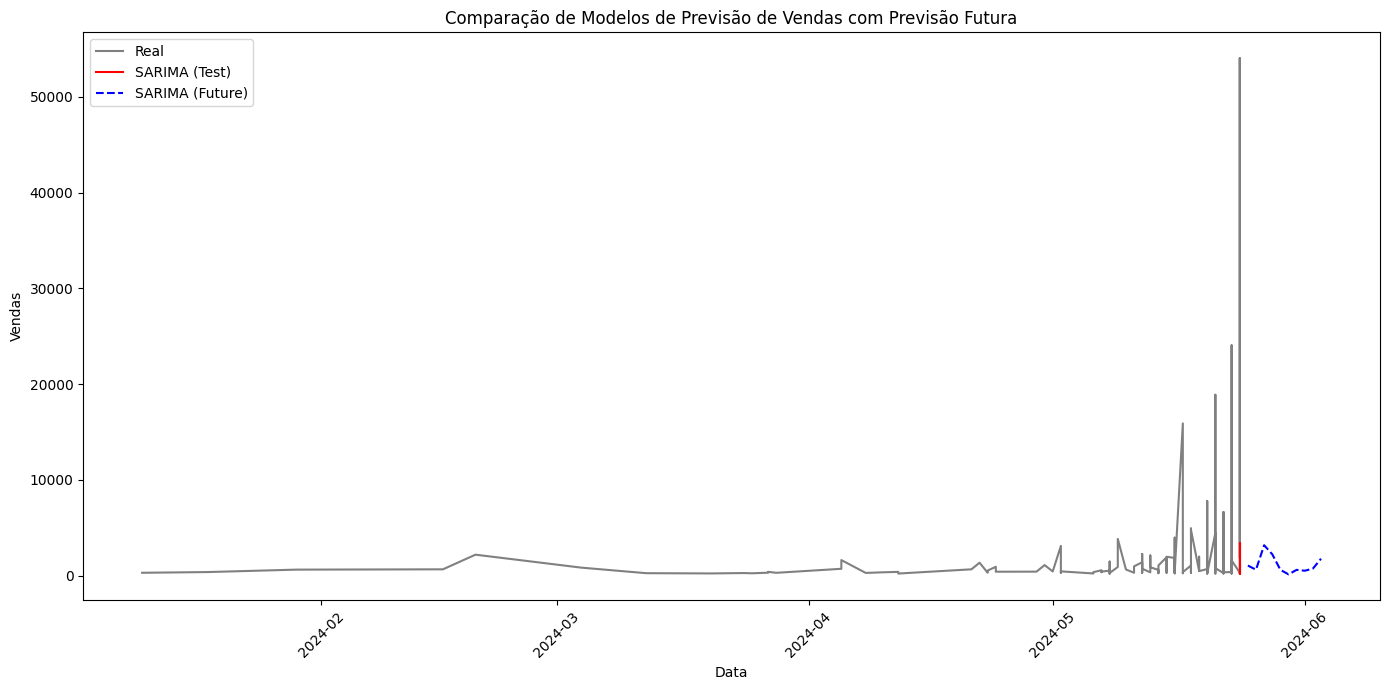

In [17]:
train_outliers, test_outliers = train_test_spli(outlier_sales)
sarima_pred, future_sarima = fit_sarima_model(train_outliers, test_outliers, 10)
# arima_pred, future_arima = fit_arima_model(train_outliers, test_outliers, 10)

plot_predictions_with_future(outlier_sales, test_outliers, sarima_pred, future_sarima, 'SARIMA')
# plot_predictions_with_future(outlier_sales, test_outliers, arima_pred, future_arima, 'ARIMA')